In [1]:
!pip install qiskit qiskit_aer pylatexenc --quiet

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, noise
from qiskit.visualization import plot_histogram


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00


In [2]:
def inverse_qft_circuit(n):
    qc = QuantumCircuit(n)
    for i in range(n//2):
        qc.swap(i, n-i-1)
    for j in range(n-1, -1, -1):
        for k in range(n-j, 1, -1):
            qc.cp(-np.pi/2**(k-1), j+k-1, j)
        qc.h(j)
    return qc


In [3]:
def phase_estimation(n_count, theta):
    qc = QuantumCircuit(n_count+1, n_count)
    for q in range(n_count):
        qc.h(q)
    for q in range(n_count):
        qc.cp(2*np.pi*theta*(2**q), q, n_count)
    qc.append(inverse_qft_circuit(n_count), range(n_count))
    display(qc.draw('mpl'))
    qc.measure(range(n_count), range(n_count))
    return qc


In [4]:
def simulate_phase_estimation(n_count, theta, noise_model=None):
    qc = phase_estimation(n_count, theta)
    sim = AerSimulator(noise_model=noise_model)
    tqc = transpile(qc, sim)
    res = sim.run(tqc, shots=2048).result()
    counts = res.get_counts()
    display(plot_histogram(counts))
    binary = max(counts, key=counts.get)
    est_phase = int(binary, 2) / 2**n_count
    print(f"Theta: {theta}, Estimated Phase: {est_phase:.3f}, Binary: {binary}")


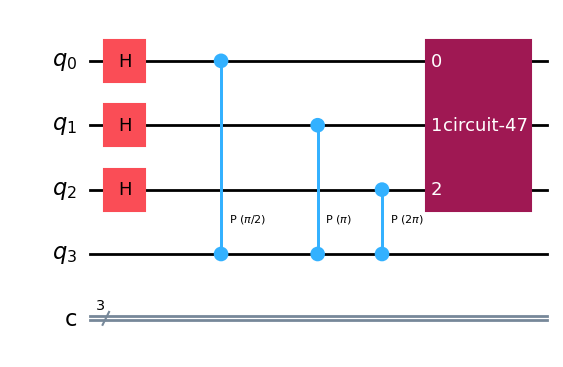

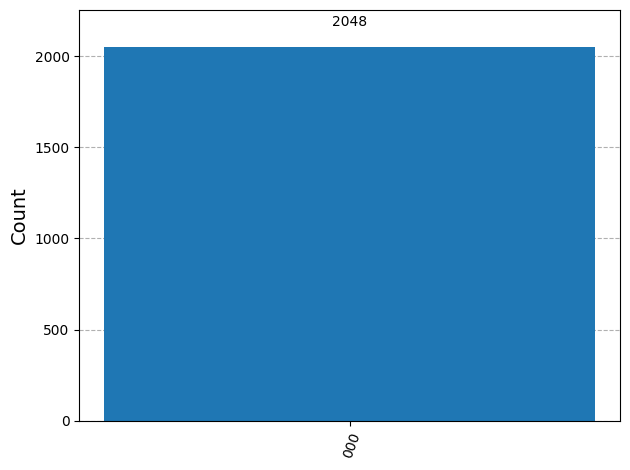

Theta: 0.25, Estimated Phase: 0.000, Binary: 000


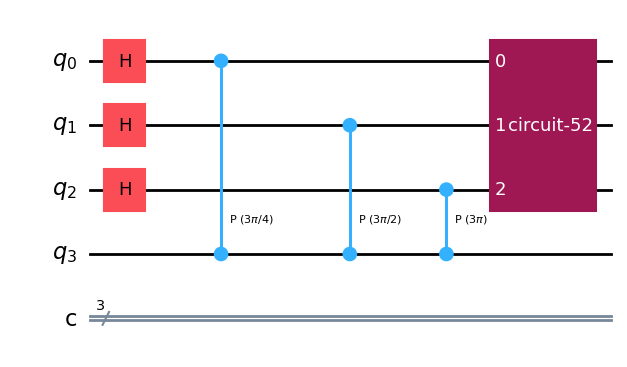

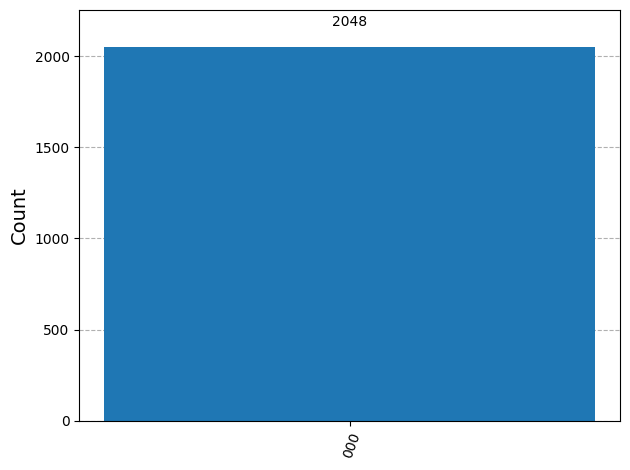

Theta: 0.375, Estimated Phase: 0.000, Binary: 000


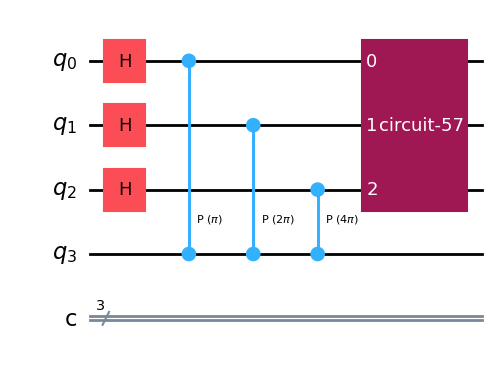

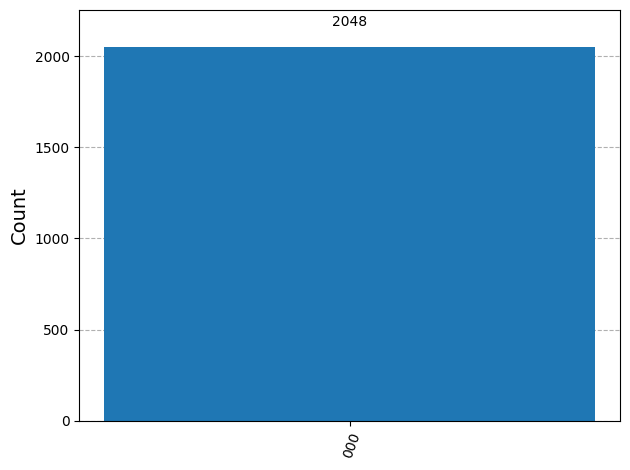

Theta: 0.5, Estimated Phase: 0.000, Binary: 000


In [5]:
for theta in [0.25, 0.375, 0.5]:
    simulate_phase_estimation(3, theta)


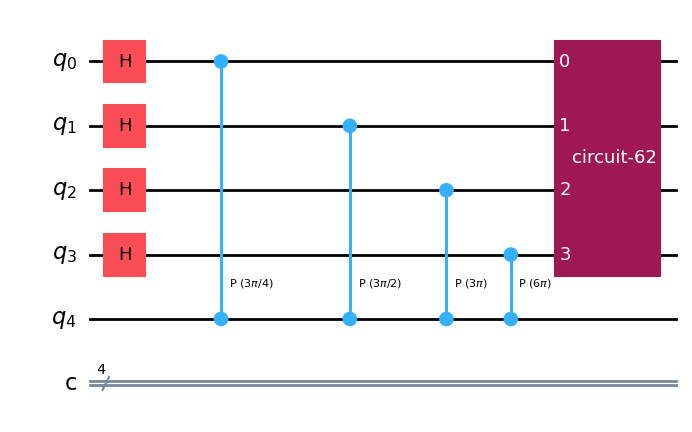

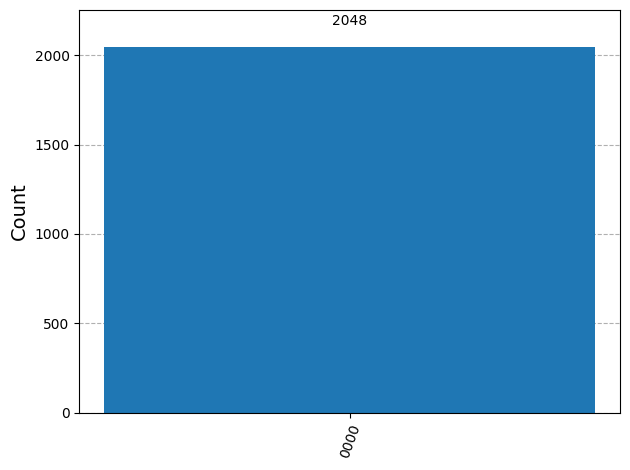

Theta: 0.375, Estimated Phase: 0.000, Binary: 0000


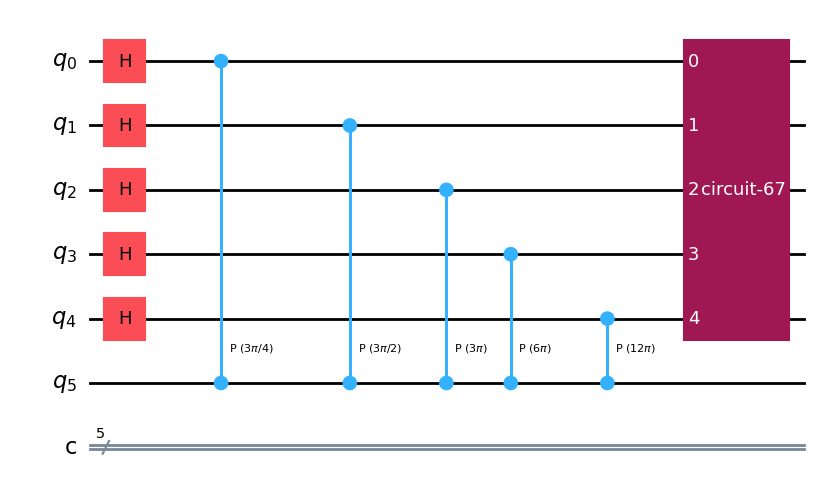

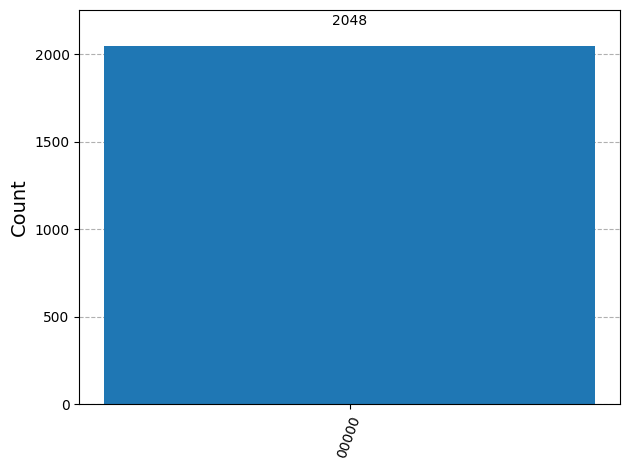

Theta: 0.375, Estimated Phase: 0.000, Binary: 00000


In [6]:
for n in [4,5]:
    simulate_phase_estimation(n, 0.375)


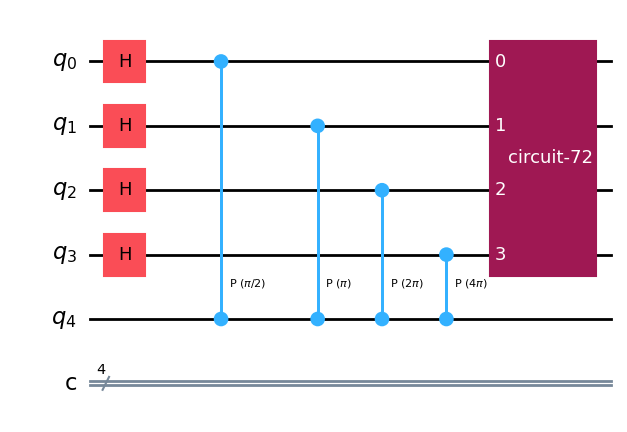

Theoretical: 0.25, Measured: 0.000


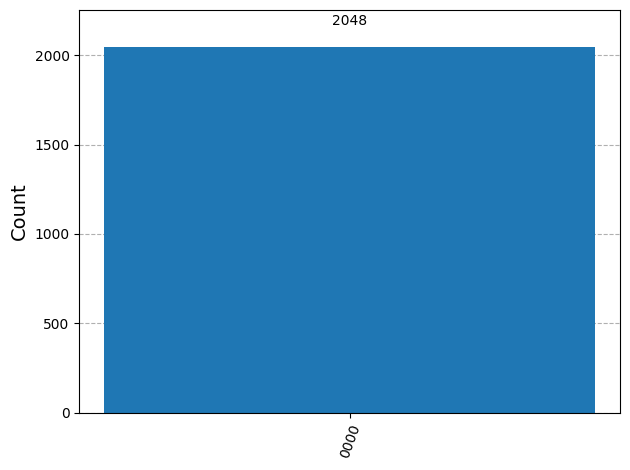

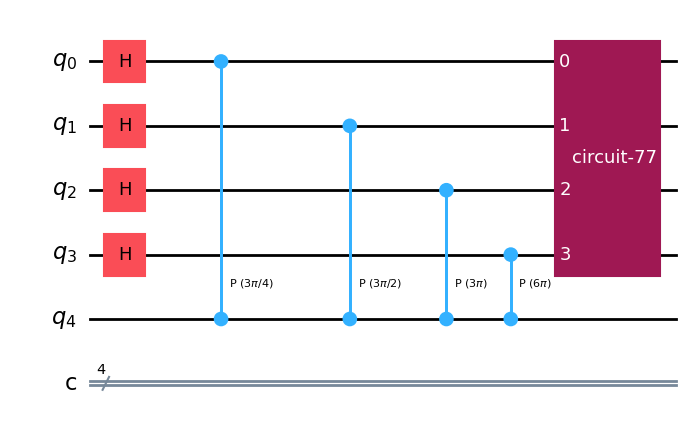

Theoretical: 0.375, Measured: 0.000


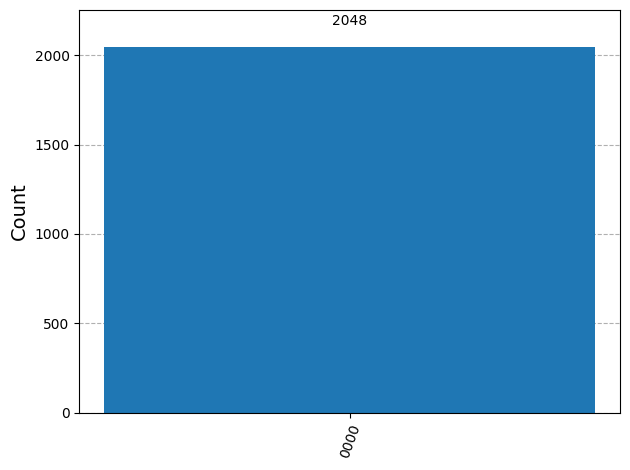

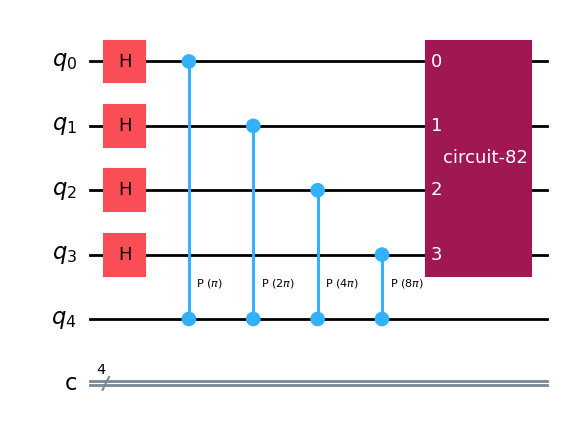

Theoretical: 0.5, Measured: 0.000


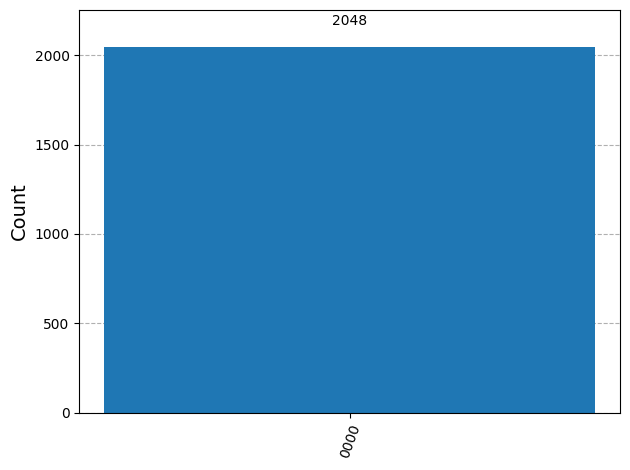

In [7]:
def compare_theoretical_vs_measured(theta, n_count):
    qc = phase_estimation(n_count, theta)
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    res = sim.run(tqc, shots=2048).result()
    counts = res.get_counts()
    binary = max(counts, key=counts.get)
    measured = int(binary, 2) / 2**n_count
    theoretical = theta % 1
    print(f"Theoretical: {theoretical}, Measured: {measured:.3f}")
    display(plot_histogram(counts))
for theta in [0.25, 0.375, 0.5]:
    compare_theoretical_vs_measured(theta, 4)


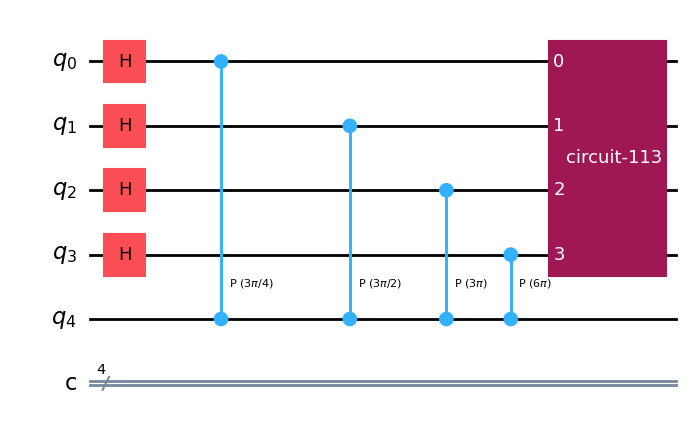

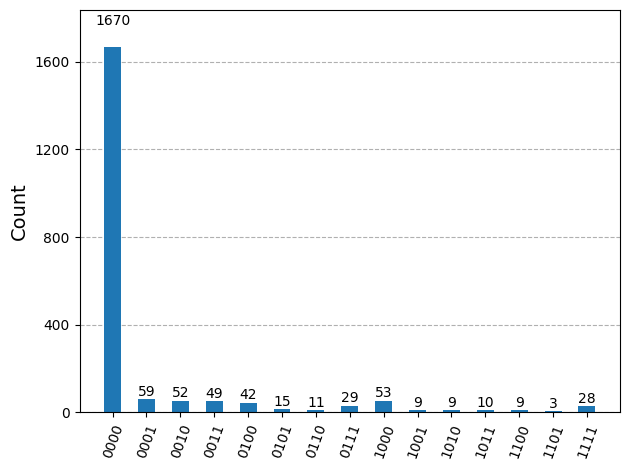

Theta: 0.375, Estimated Phase: 0.000, Binary: 0000


In [9]:
error_prob = 0.02
noise_model = noise.NoiseModel()
error_1 = noise.depolarizing_error(error_prob, 1)
error_2 = noise.depolarizing_error(error_prob, 2)
noise_model.add_all_qubit_quantum_error(error_1, ['h'])
noise_model.add_all_qubit_quantum_error(error_2, ['cp'])

simulate_phase_estimation(4, 0.375, noise_model=noise_model)
